<IPython.core.display.Javascript object>


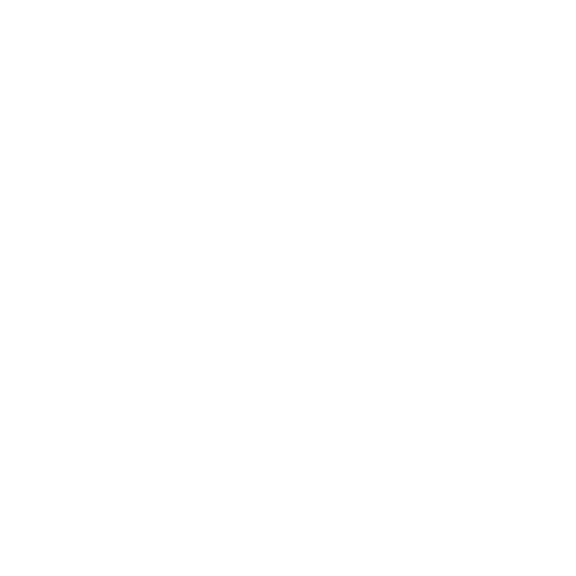

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [5]:
class ResetMcl(Mcl):
    def __init__(self, envmap,  init_pose,num, motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},\
                distance_dev_rate = 0.14, direction_dev = 0.05):
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alphas = {} # αの記録（ランドマークの観測数ごと）
        
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
            
        # αの記録
        alpha = sum([p.weight for p in self.particles]) # 重みの合計を記録
        obsnum = len(observation)
        if not obsnum in self.alphas: self.alphas[obsnum] = []
        self.alphas[obsnum].append(alpha)
        
        self.set_ml()
        self.resampling() # 重みの合計１

<IPython.core.display.Javascript object>


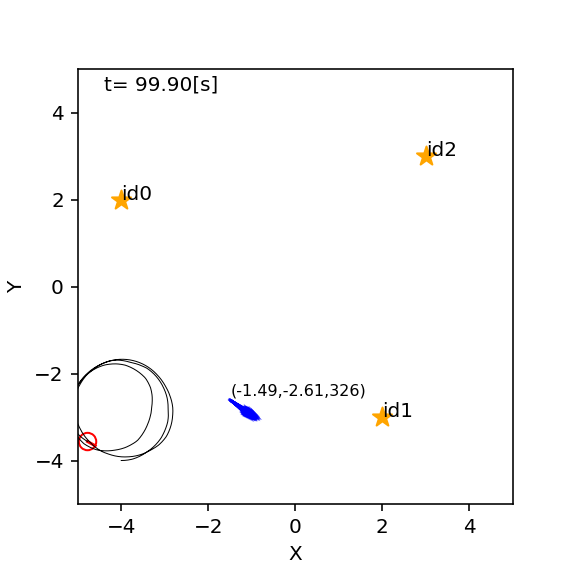

In [10]:
def trial():
    time_interval = 0.1
    world = World(40,time_interval,debug = True)
    
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0,0,0]).T
    robot_pose = np.array([-4, -4, 0]).T
    pf = ResetMcl(m, initial_pose, 100)
    a = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,pf)
    r = Robot(robot_pose, sensor = Camera(m),agent = a,color = "red") # このカメラ、ファントム、オクルージョン...全部込み込み
    world.append(r)
    
    world.draw()
    return pf
    
pf = trial()

In [11]:
for num in pf.alphas:
    print("landmarks:", num, "particles:", len(pf.particles), "min:", min(pf.alphas[num]), "max", max(pf.alphas[num]))

landmarks: 1 particles: 100 min: 0.0 max 3.4804814033585814
landmarks: 0 particles: 100 min: 1.0000000000000007 max 1.0000000000000007
landmarks: 3 particles: 100 min: 0.0 max 0.0
landmarks: 2 particles: 100 min: 0.0 max 5.869610649911561e-55


In [9]:
# 研究室のパソコンでうごかしたい